# ENSO Region Variability

This notebook plots basic ENSO variability.

### MAR Configuration

In [1]:
config = {
    "startyr": "1998",
    "endyr": "2017",
    "dora_id": "odiv-484",
    "pathPP": "",
}

In [2]:
# Make sure this cell is active so that the workflow and Dora can update
# the config dictionary at runtime.

from gfdlnb.tools.update_notebook_config import update_notebook_config
config = update_notebook_config(config)

In [3]:
import os
import datetime

In [4]:
import os
import datetime
import doralite
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import doralite
import glob
import subprocess
import momlevel
import itertools
import xwavelet as xw
import momgrid as mg
from datetime import timedelta

In [5]:
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

In [6]:
#List of all experiments to consider
experiments = [doralite.dora_metadata(x) for x in config["dora_id"].split(",")]

# Define start and end years
start = config["startyr"]
start = int(start) if start is not None else 1

end = config["endyr"]
end = int(end) if end is not None else 9999

### Load Files

In [7]:
def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

In [8]:
datafiles = []
staticfiles = []

for experiment in experiments:
    _pathPP = experiment["pathPP"]
    
    component = "ocean_monthly"
    static = f"{component}/{component}.static.nc"
    varname = "tos"
    
    chunk = "5yr"
    filelist = sorted(glob.glob(f"{_pathPP}{component}/ts/monthly/{chunk}/{component}.*.{varname}.nc"))
    
    filelist = [x for x in filelist if is_in_range(x,start,end)]
    _staticfile = f"{_pathPP}/{static}"
    
    staticfiles.append(_staticfile)
    datafiles.append(filelist)

In [9]:
allfiles = sorted(list(itertools.chain(*datafiles)) + staticfiles)
_ = [print(x) for x in allfiles]

/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp//ocean_monthly/ocean_monthly.static.nc
/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.199801-200212.tos.nc
/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.200301-200712.tos.nc
/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.200801-201212.tos.nc
/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.201301-201712.tos.nc


In [10]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+allfiles
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Calculations and Plots from CM4X Notebook

In [11]:
# Open dataset
ds = mg.Gridset(filelist).data

# Nino3.4 SST
nino34 = mg.geoslice.geoslice(ds.tos,y=(-5,5),x=(-170,-120))
nino34 = nino34.weighted(nino34.areacello).mean(("yh","xh"))
nino34 = nino34.load()

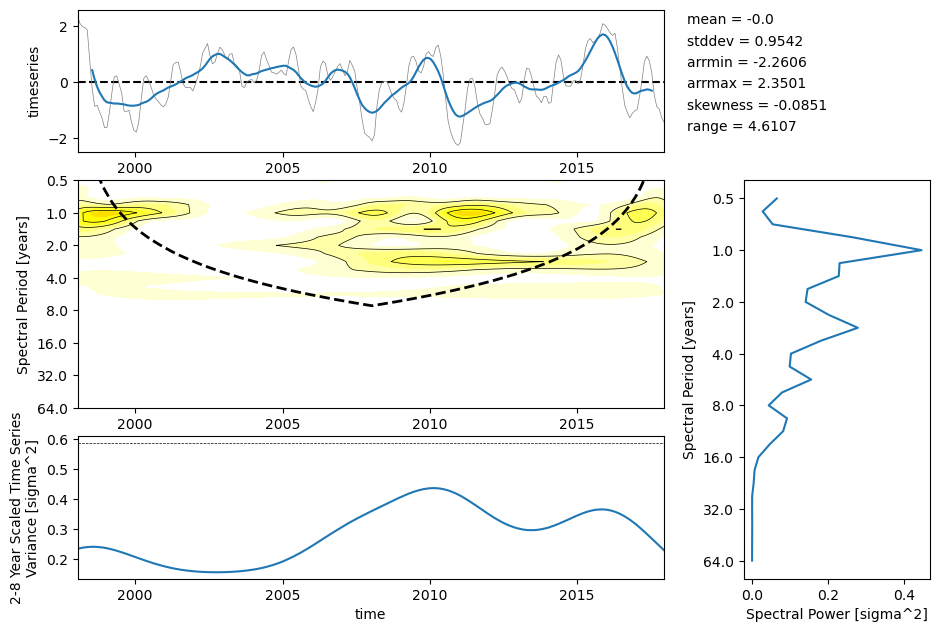

In [12]:
# Figure
result = xw.Wavelet(nino34, scaled=True)
fig = result.composite()